In [1]:
import numpy as np
from PIL import Image, ImageOps

import os
import json
import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 20)

In [2]:
def pad_data(data, divisor=16):
    shape_y, shape_x = data.shape

    target_y_size = math.ceil(shape_y / divisor) * divisor
    target_x_size = math.ceil(shape_x / divisor) * divisor

    padding_top = round((target_y_size - shape_y) / 2)
    padding_bottom = target_y_size - shape_y - padding_top
    padding_left = round((target_x_size - shape_x) / 2)
    padding_right = target_x_size - shape_x - padding_left

    return np.pad(data, pad_width=((padding_top, padding_bottom), (padding_left, padding_right)), mode='edge'), [padding_top, padding_bottom, padding_left, padding_right]

In [3]:
DIVISOR = 32
RAW_PATH = os.path.join('data', 'raw', 'numpy')
SAVE_PATH = os.path.join('data', 'complete')

raw_files = [['inline_data.npz', 'inline_faults_thick_7.npz']]

fault_path = os.path.join(SAVE_PATH, 'fault')
seis_path = os.path.join(SAVE_PATH, 'seis')
img_cnt = 0
metadata = []
for data_names in raw_files:
    print(data_names)
    data = np.load(os.path.join(RAW_PATH, data_names[0]))['arr_0']
    min_data_value = np.min(data)
    max_data_value = np.max(data)
    data = (data - min_data_value) / (max_data_value - min_data_value) * 255

    labels = np.load(os.path.join(RAW_PATH, data_names[1]))['arr_0']
    assert data.shape == labels.shape

    for iline_num in range(np.shape(data)[0]):
        data_slice = data[iline_num]
        labels_slice = labels[iline_num]

        timelines, jlines,  = np.shape(data_slice)
        data_slice, data_padding = pad_data(data_slice, DIVISOR)
        labels_slice, labels_padding = pad_data(labels_slice, DIVISOR)
        labels_slice = labels_slice * 255

        data_img = ImageOps.grayscale(Image.fromarray(data_slice))
        label_img = ImageOps.grayscale(Image.fromarray(labels_slice))
        metadata.append({
                'data': f'{img_cnt}.png',
                'label': f'{img_cnt}.png',
                'padding': data_padding
            })
        data_img.save(os.path.join(seis_path, f'{img_cnt}.png'))
        label_img.save(os.path.join(fault_path, f'{img_cnt}.png'))
        img_cnt += 1
with open(os.path.join(SAVE_PATH, 'metadata.json'), 'w') as file:
    json.dump(metadata, file)

['inline_data.npz', 'inline_faults_thick_7.npz']


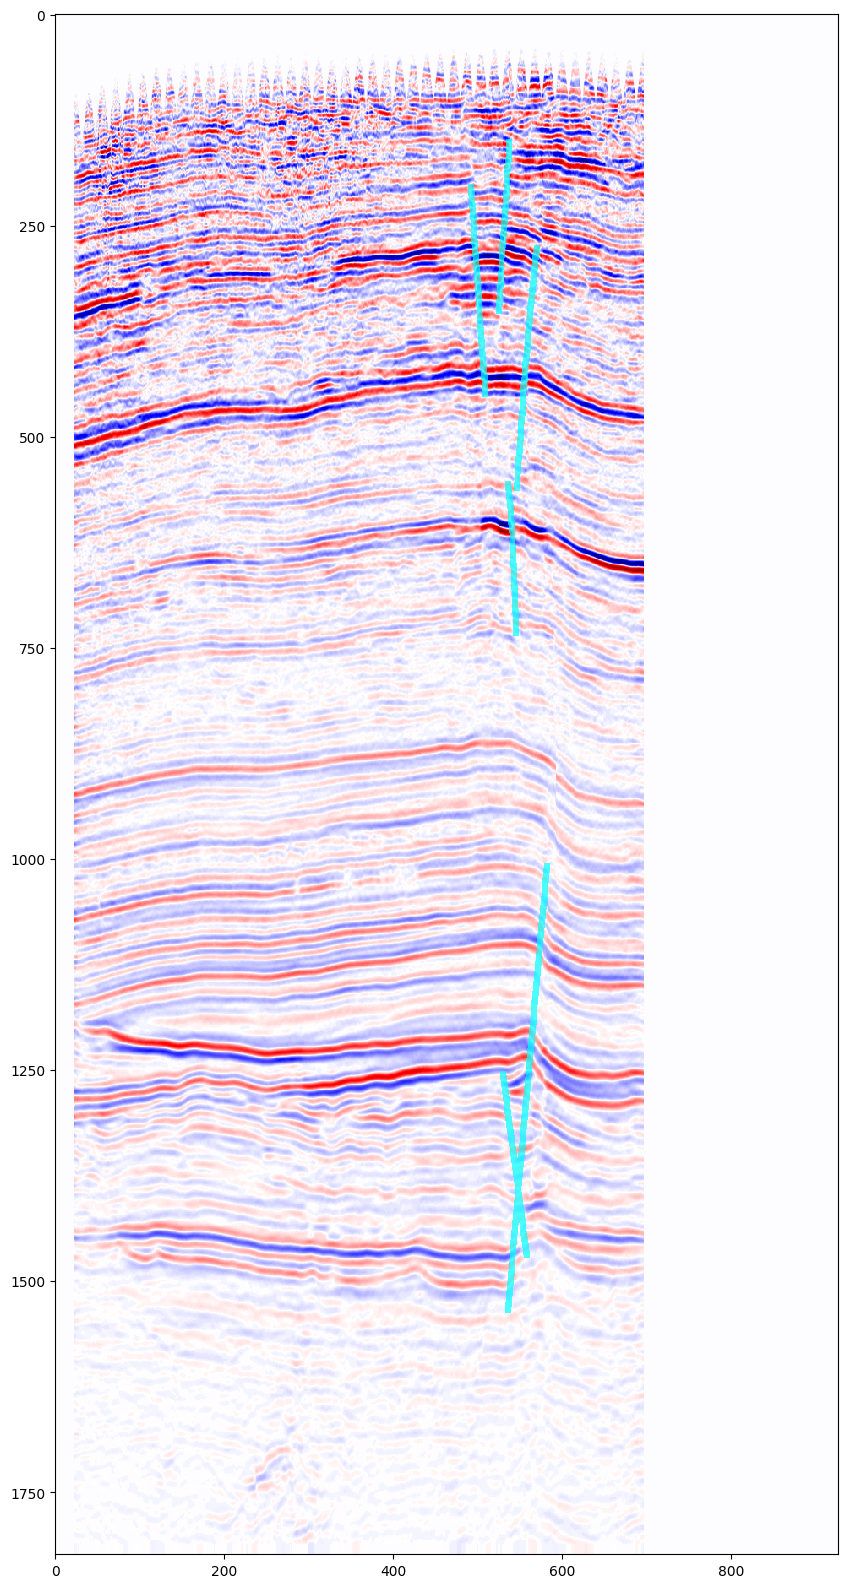

In [55]:
iline_test_num = 567
record = metadata[iline_test_num]
data = np.asarray(Image.open(os.path.join(seis_path, record['data'])))
labels = np.asarray(Image.open(os.path.join(fault_path, record['label'])))

fig, ax = plt.subplots()
ax.imshow(data, cmap='seismic', interpolation='none')
mask = np.ma.masked_less(labels, 0.8)
ax.imshow(mask, cmap='cool', interpolation='none', alpha=0.7)
plt.show()

In [4]:
DIVISOR = 32
RAW_PATH = os.path.join('data', 'raw', 'numpy')
SAVE_PATH = os.path.join('data', 'complete')

raw_files = [['inline_data.npz', 'inline_faults_thick_7.npz']]

fault_path = os.path.join(SAVE_PATH, 'fault_thick')
img_cnt = 0
metadata = []
for data_names in raw_files:
    print(data_names)

    labels = np.load(os.path.join(RAW_PATH, data_names[1]))['arr_0']

    for iline_num in range(np.shape(labels)[0]):
        labels_slice = labels[iline_num]
        labels_slice, labels_padding = pad_data(labels_slice, DIVISOR)
        labels_slice = labels_slice * 255

        label_img = ImageOps.grayscale(Image.fromarray(labels_slice))
        metadata.append({
                'data': f'{img_cnt}.jpeg',
                'label': f'{img_cnt}.jpeg',
                'padding': labels_padding
            })
        label_img.save(os.path.join(fault_path, f'{img_cnt}.jpeg'))
        img_cnt += 1
with open(os.path.join(SAVE_PATH, 'metadata_thick.json'), 'w') as file:
    json.dump(metadata, file)

['inline_data.npz', 'inline_faults_thick.npz']


In [5]:
RAW_PATH = os.path.join('data', 'raw', 'numpy')
SAVE_PATH = os.path.join('data', 'complete')
fault_path = os.path.join(SAVE_PATH, 'fault')
seis_path = os.path.join(SAVE_PATH, 'seis')
fault_thick_path = os.path.join(SAVE_PATH, 'fault_thick')
with open(os.path.join(SAVE_PATH, 'metadata_thick.json'), 'r') as file:
    metadata = json.load(file)

758.4901960784314


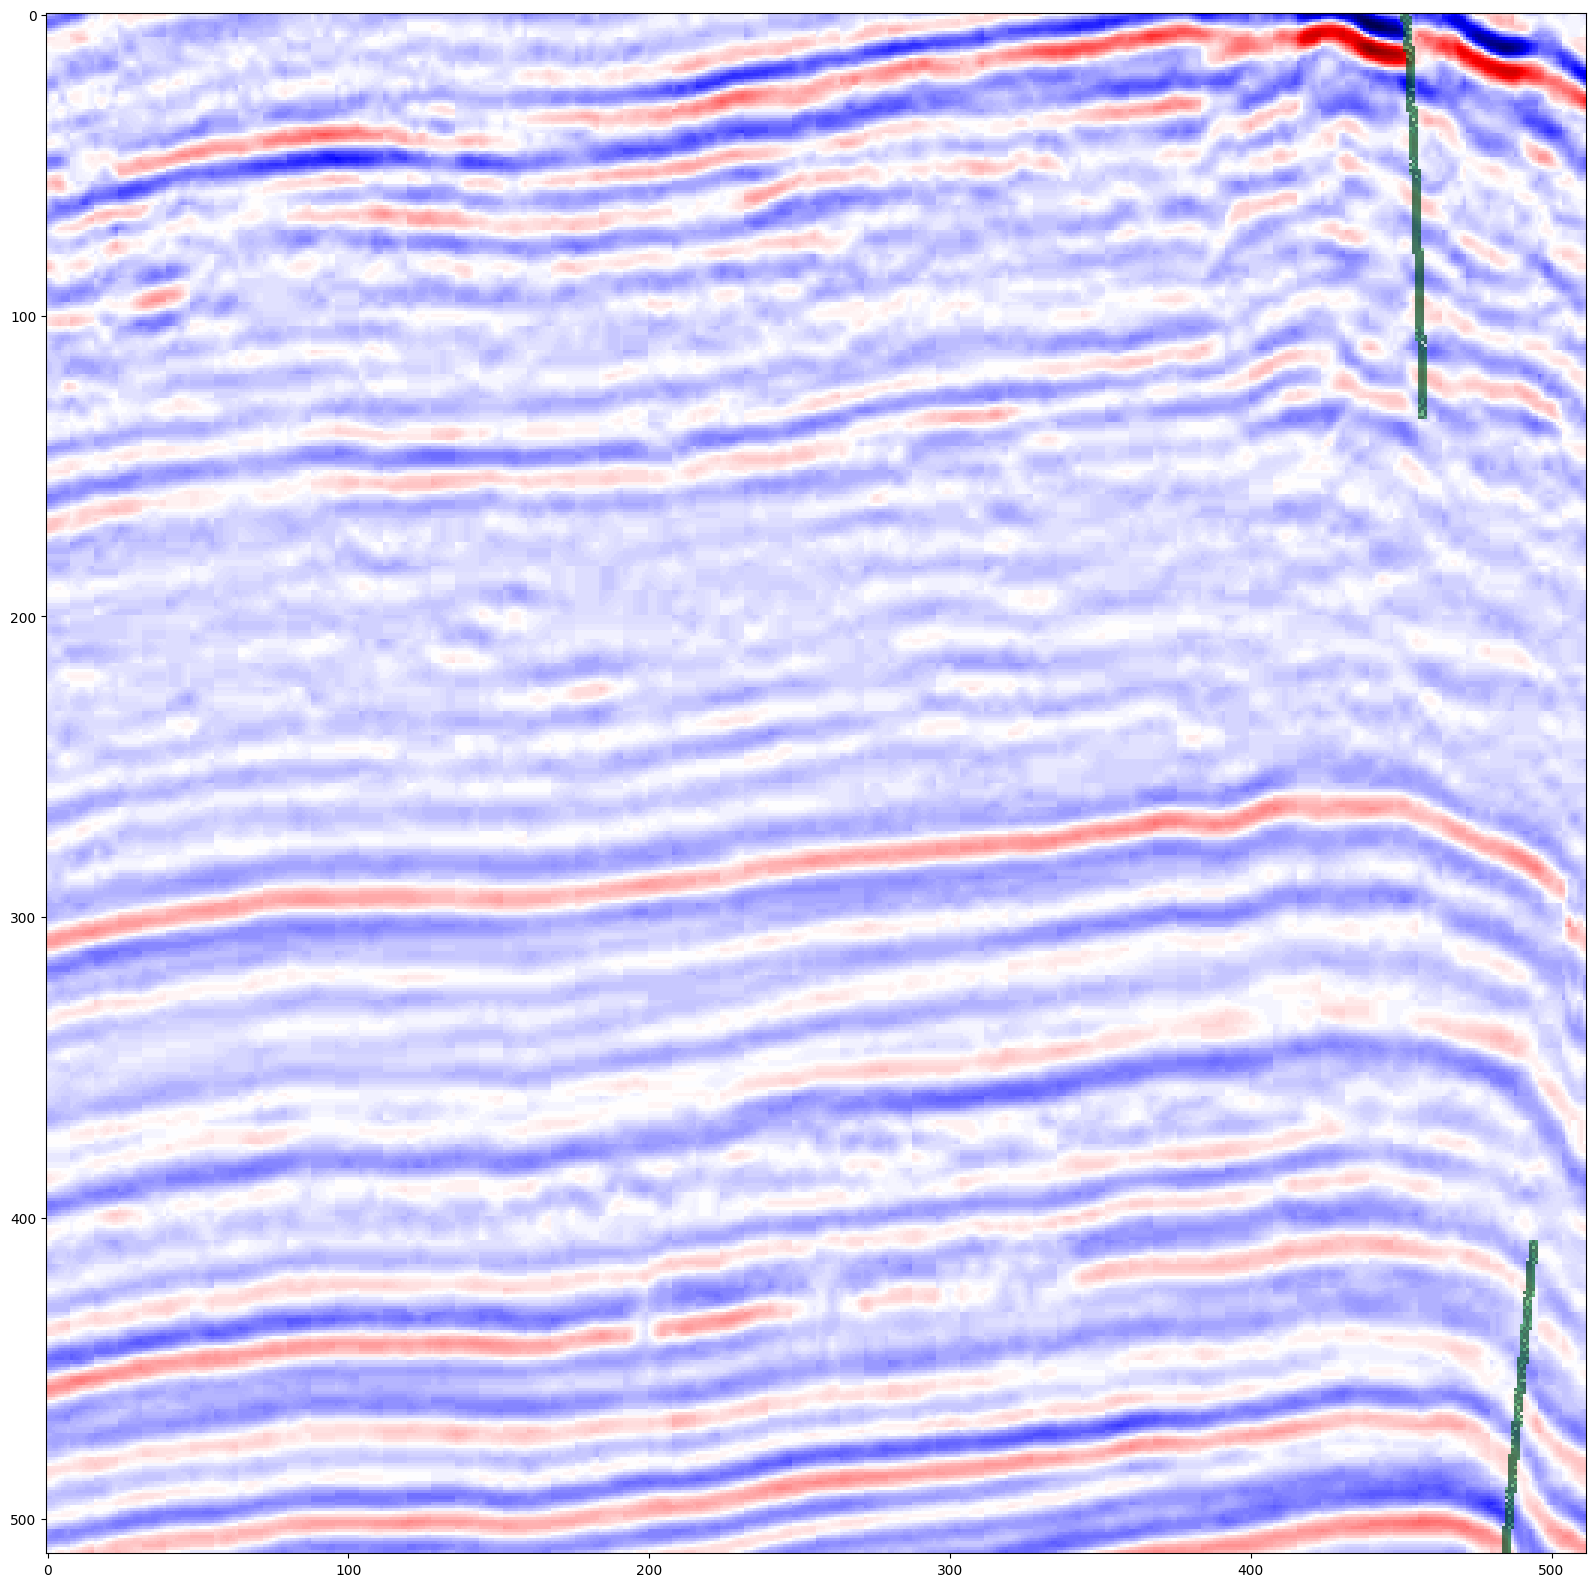

In [86]:
jpeg_thresh = 0.2

iline_test_num = 567
record = metadata[iline_test_num]
data = np.asarray(Image.open(os.path.join(seis_path, record['data'])))[600:1112,88:600]
labels = np.asarray(Image.open(os.path.join(fault_thick_path, record['label'])))[600:1112,88:600]
print(np.sum(labels) / 255)

fig, ax = plt.subplots()
ax.imshow(data, cmap='seismic', interpolation='none')
# mask = np.ma.masked_less(n_labels, 0.2)
mask = np.ma.masked_less(labels, jpeg_thresh * 255)
ax.imshow(mask, cmap='Greens', interpolation='none', alpha=0.7)
plt.show()